# **Dịch máy Anh-Pháp với mô hình Encoder-Decoder**

## 1. Chuẩn bị vấn đề

### 1.1. Import các thư viện cần thiết
Các yêu cầu hệ thống:
- Python phiên bản 3.10.18
- Pytorch phiên bản 2.1.0 (có hỗ trợ CUDA)
- Torchtext phiên bản 0.16.0
- NLTK phiên bản 3.9.1

In [22]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

### 1.2. Chọn thiết bị làm việc trên Pytorch

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Kiểm tra liên kết thiết bị
if DEVICE.type == 'cuda':
    print("CUDA is available.")
    print("Device name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available, using CPU.")

CUDA is available.
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA version: 12.1


### 1.3. Thiết lập random seed ngẫu nhiên để bảo đảm tính tái tạo
Chạy command này trên CommandPrompt trước khi chạy chương trình: __set CUBLAS_WORKSPACE_CONFIG=:4096:8__. Tắt bằng __set CUBLAS_WORKSPACE_CONFIG=__

In [24]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)

# Dataloader deterministic
g = torch.Generator()
g.manual_seed(SEED)

rng = torch.Generator()
rng.manual_seed(SEED)

## 2. Chuẩn bị dữ liệu và xử lý dữ liệu

### 2.1. Tải dữ liệu train, validation, test

In [25]:
def load_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [l.strip() for l in f if l.strip()]
    
train_en = load_lines("./data/train.en")
train_fr = load_lines("./data/train.fr")
val_en   = load_lines("./data/val.en")
val_fr   = load_lines("./data/val.fr")
test_en  = load_lines("./data/test.en")
test_fr  = load_lines("./data/test.fr")

In [26]:
# kiểm tra dữ liệu
print("Train EN: ", train_en[1:10])
print("Train FR: ", train_fr[1:10])
print("Validation EN: ", val_en[1:10])
print("Validation FR: ", val_fr[1:10])
print("Test EN: ", test_en[1:10])
print("Test FR: ", test_fr[1:10])

Train EN:  ['Several men in hard hats are operating a giant pulley system.', 'A little girl climbing into a wooden playhouse.', 'A man in a blue shirt is standing on a ladder cleaning a window.', 'Two men are at the stove preparing food.', 'A man in green holds a guitar while the other man observes his shirt.', 'A man is smiling at a stuffed lion', 'A trendy girl talking on her cellphone while gliding slowly down the street.', 'A woman with a large purse is walking by a gate.', 'Boys dancing on poles in the middle of the night.']
Train FR:  ['Plusieurs hommes en casque font fonctionner un système de poulies géant.', 'Une petite fille grimpe dans une maisonnette en bois.', 'Un homme dans une chemise bleue se tient sur une échelle pour nettoyer une fenêtre.', 'Deux hommes aux fourneaux préparent à manger.', "Un homme en vert tient une guitare tandis qu'un autre homme observe sa chemise.", 'Un homme sourit à un ours en peluche.', 'Une fille branchée parle à son portable tout en glissant l

### 2.2. Tokenization
Thực hiện chuyển các câu thành danh sách token dùng tokenizer của spacy

In [27]:
PAD_TOK = "<pad>"
UNK_TOK = "<unk>"
SOS_TOK = "<sos>"
EOS_TOK = "<eos>"

In [28]:
# Hàm tokenizer
def tokenize(s):
    return s.lower().strip().split()

# Hàm thêm token <sos> ở đầu chuỗi và <eos> ở cuối chuỗi
def add_sos_eos(toks):
    return [SOS_TOK] + toks + [EOS_TOK]

In [29]:
train_en_tok = [add_sos_eos(tokenize(s)) for s in train_en]
train_fr_tok = [add_sos_eos(tokenize(s)) for s in train_fr]
val_en_tok   = [add_sos_eos(tokenize(s)) for s in val_en]
val_fr_tok   = [add_sos_eos(tokenize(s)) for s in val_fr]
test_en_tok  = [add_sos_eos(tokenize(s)) for s in test_en]
test_fr_tok  = [add_sos_eos(tokenize(s)) for s in test_fr]

In [30]:
# Kiểm tra
print("Train EN (tokenized): ", train_en_tok[1:10])
print("Train FR (tokenized): ", train_fr_tok[1:10])
print("Validation EN (tokenized): ", val_en_tok[1:10])
print("Validation FR (tokenized): ", val_fr_tok[1:10])
print("Test EN (tokenized): ", test_en_tok[1:10])
print("Test FR (tokenized): ", test_fr_tok[1:10])

Train EN (tokenized):  [['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system.', '<eos>'], ['<sos>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse.', '<eos>'], ['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window.', '<eos>'], ['<sos>', 'two', 'men', 'are', 'at', 'the', 'stove', 'preparing', 'food.', '<eos>'], ['<sos>', 'a', 'man', 'in', 'green', 'holds', 'a', 'guitar', 'while', 'the', 'other', 'man', 'observes', 'his', 'shirt.', '<eos>'], ['<sos>', 'a', 'man', 'is', 'smiling', 'at', 'a', 'stuffed', 'lion', '<eos>'], ['<sos>', 'a', 'trendy', 'girl', 'talking', 'on', 'her', 'cellphone', 'while', 'gliding', 'slowly', 'down', 'the', 'street.', '<eos>'], ['<sos>', 'a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate.', '<eos>'], ['<sos>', 'boys', 'dancing', 'on', 'poles', 'in', 'the', 'middle', 'of', 'the', 'night.', '<eos>']]
Train FR

### 2.3. Xây dựng từ điển
Xây dựng từ điển dùng build_vocal_from_iterator của pytorchtext với các token đặc biệt là $<unk>, <pad>, <sos>, <eos>$ và giới hạn 10000 từ phổ biến nhất

In [31]:
MAX_VOCAB = 10000

vocab_en = build_vocab_from_iterator(iter(train_en_tok),
                                     specials=[UNK_TOK, PAD_TOK, SOS_TOK, EOS_TOK],
                                     max_tokens=MAX_VOCAB)
vocab_fr = build_vocab_from_iterator(iter(train_fr_tok),
                                     specials=[UNK_TOK, PAD_TOK, SOS_TOK, EOS_TOK],
                                     max_tokens=MAX_VOCAB)

# Đặt index mặc định là <unk>
vocab_en.set_default_index(vocab_en[UNK_TOK])
vocab_fr.set_default_index(vocab_fr[UNK_TOK])

In [32]:
# Kiểm tra 
print("Vocab EN (first 20 words): ", vocab_en.get_itos()[:20])
print("Vocab FR (first 20 words): ", vocab_fr.get_itos()[:20])

Vocab EN (first 20 words):  ['<unk>', '<pad>', '<sos>', '<eos>', 'a', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'two', 'woman', 'are', 'to', 'at', 'people', 'an']
Vocab FR (first 20 words):  ['<unk>', '<pad>', '<sos>', '<eos>', 'un', 'une', 'de', 'en', 'dans', 'sur', 'homme', 'et', 'des', 'avec', 'la', 'à', 'femme', 'deux', 'le', "d'un"]


### 2.4. Xây dựng tensor
Thực hiện chuyển đổi dữ liệu từ dạng chuỗi sang dạng tensor.

In [33]:
# Hàm chuyển đổi từ token sang tensor
def tokToTensor(toks, vocab):
    return torch.tensor([vocab[t] for t in toks], dtype=torch.long)

train_en_t = [tokToTensor(t, vocab_en) for t in train_en_tok]
train_fr_t = [tokToTensor(t, vocab_fr) for t in train_fr_tok]
val_en_t   = [tokToTensor(t, vocab_en) for t in val_en_tok]
val_fr_t   = [tokToTensor(t, vocab_fr) for t in val_fr_tok]
test_en_t  = [tokToTensor(t, vocab_en) for t in test_en_tok]
test_fr_t  = [tokToTensor(t, vocab_fr) for t in test_fr_tok]

### 2.5. Tạo DataLoader
Chuẩn bị dữ liệu theo batch, padding và sắp xếp theo độ dài giảm dần

In [34]:
PAD_EN = vocab_en[PAD_TOK] # lấy ra <pad> của tiếng Anh
PAD_FR = vocab_fr[PAD_TOK] # lấy ra <pad> của tiếng Pháp
BATCH = 64

# Hàm collate 
def collate_fn(batch):
    ens = [x[0] for x in batch]
    frs = [x[1] for x in batch]

    # Pad
    pad_en = pad_sequence(ens, batch_first=True, padding_value=PAD_EN)
    pad_fr = pad_sequence(frs, batch_first=True, padding_value=PAD_FR)

    # Lengths trước sort
    len_en = (pad_en != PAD_EN).sum(1)

    # Sort theo độ dài giảm dần
    len_en_sorted, indices = torch.sort(len_en, descending=True)

    # Áp dụng sort
    pad_en = pad_en[indices]
    pad_fr = pad_fr[indices]

    return pad_en, pad_fr, len_en_sorted

# Gom dữ liệu thành 2 tập train và test
train_data = list(zip(train_en_t, train_fr_t))
val_data   = list(zip(val_en_t, val_fr_t))

# Tạo dataLoader
train_loader = DataLoader(
    train_data, batch_size=BATCH, shuffle=True,
    collate_fn=collate_fn, generator=g
)
val_loader = DataLoader(
    val_data, batch_size=BATCH, shuffle=False,
    collate_fn=collate_fn, generator=g
)

## 3. Thiết lập mô hình huấn luyện

### 3.1. Thiết lập mô hình Sequence To Sequence

In [35]:
# Các tham số mô hình
EMB = 512
HID = 512
LAYERS = 2 
DROPOUT = 0.3
EPOCHS = 10 
LR = 0.001 
TFR = 0.5

class Seq2Seq(nn.Module):
    def __init__(self, vocab_in, vocab_out,
                 emb, hid, layers,
                 pad_idx, sos_idx, dropout):

        super().__init__()
        self.hid = hid
        self.layers = layers
        self.sos_idx = sos_idx

        # Encoder
        self.emb_enc = nn.Embedding(vocab_in, emb, padding_idx=pad_idx)
        self.enc = nn.LSTM(emb, hid, layers,
                           batch_first=True, dropout=dropout)

        # Decoder
        self.emb_dec = nn.Embedding(vocab_out, emb, padding_idx=pad_idx)
        self.dec = nn.LSTM(emb, hid, layers,
                           batch_first=True, dropout=dropout)

        self.out = nn.Linear(hid, vocab_out)

    def forward(self, src, src_len, trg=None, tf_ratio = TFR, rng=None):
        B = src.size(0)

        # Encoder
        emb = self.emb_enc(src)
        packed = pack_padded_sequence(emb, src_len.cpu(),
                                      batch_first=True, enforce_sorted=False)
        _, (h, c) = self.enc(packed)

        # Decoder
        T = trg.size(1) if trg is not None else 50
        inp = torch.full((B, 1), self.sos_idx,
                         dtype=torch.long, device=src.device)

        outputs = torch.zeros(B, T, self.out.out_features, device=src.device)
        dec_h, dec_c = h, c

        for t in range(T):
            emb = self.emb_dec(inp)
            dec_out, (dec_h, dec_c) = self.dec(emb, (dec_h, dec_c))
            logits = self.out(dec_out)          # (B,1,V)
            outputs[:, t] = logits.squeeze(1)

            if trg is not None:
                if rng is not None:
                    use_tf = (torch.rand(1, generator=rng).item() < tf_ratio)
                else:
                    use_tf = (torch.rand(1).item() < tf_ratio)

                inp = trg[:, t].unsqueeze(1) if use_tf else logits.argmax(-1)
            else:
                inp = logits.argmax(-1)

        return outputs

### 3.2. Thiết lập CrossEntropyLoss, Adam và SmoothingFunction

In [36]:
# Khởi tạo các thành phần cho huấn luyện
model = Seq2Seq(len(vocab_en), len(vocab_fr),
                emb=EMB, hid=HID, layers=LAYERS,
                pad_idx=PAD_FR, sos_idx=vocab_fr[SOS_TOK],
                dropout=DROPOUT).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_FR)
opt = optim.Adam(model.parameters(), lr=LR)
smooth = SmoothingFunction().method1

## 4. Huấn luyện mô hình

In [37]:
def tf_ratio_for_epoch(ep):
    return max(0.5, 0.9 * (0.95 ** (ep - 1)))

best_val = 1e9
best_state = None

train_loss_list = []
val_loss_list = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    tloss = 0
    tf_r = tf_ratio_for_epoch(epoch)

    # Train
    for pad_en, pad_fr, len_en in train_loader:

        # Chuyển dữ liệu phù hợp với thiết bị tương ứng
        pad_en = pad_en.to(DEVICE)
        pad_fr = pad_fr.to(DEVICE)
        len_en = len_en.to(DEVICE)

        opt.zero_grad()
        logits = model(pad_en, len_en, trg=pad_fr, tf_ratio=tf_r, rng=rng)
        loss = criterion(logits.reshape(-1, logits.size(-1)),
                         pad_fr.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        tloss += loss.item()

    tloss /= len(train_loader)

    # Validation
    model.eval()
    vloss = 0
    with torch.no_grad():
        for pad_en, pad_fr, len_en in val_loader:
            pad_en = pad_en.to(DEVICE)
            pad_fr = pad_fr.to(DEVICE)
            len_en = len_en.to(DEVICE)

            logits = model(pad_en, len_en, trg=pad_fr,
                           tf_ratio=0.0, rng=rng)
            loss = criterion(logits.reshape(-1, logits.size(-1)),
                             pad_fr.reshape(-1))
            vloss += loss.item()

    vloss /= len(val_loader)

    if vloss < best_val:
        best_val = vloss
        best_state = copy.deepcopy(model.state_dict())

    train_loss_list.append(tloss)
    val_loss_list.append(vloss)

    print(f"Epoch {epoch}: Train Loss={tloss:.4f}, Val Loss={vloss:.4f}")

# Lưu mô hình huấn luyện
torch.save(best_state, "best_seq2seq.pth")
print("Model saved.")

Epoch 1: Train Loss=4.2022, Val Loss=5.1679
Epoch 2: Train Loss=3.0816, Val Loss=4.5480
Epoch 3: Train Loss=2.6401, Val Loss=4.2291
Epoch 4: Train Loss=2.3342, Val Loss=4.0457
Epoch 5: Train Loss=2.1095, Val Loss=3.8399
Epoch 6: Train Loss=1.8978, Val Loss=3.6824
Epoch 7: Train Loss=1.7301, Val Loss=3.6246
Epoch 8: Train Loss=1.5770, Val Loss=3.5726
Epoch 9: Train Loss=1.4496, Val Loss=3.5044
Epoch 10: Train Loss=1.3396, Val Loss=3.3952
Model saved.


## 5. Đánh giá mô hình

### 5.1. Đánh giá hiệu suất train và validation

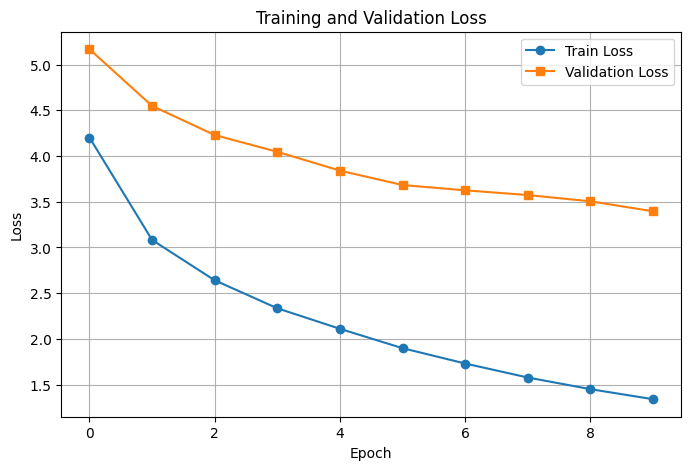

In [38]:
plt.figure(figsize=(8, 5))

plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(val_loss_list, label="Validation Loss", marker='s')

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.show()

### 5.2. Đánh giá BLEU Score và Perplexity trên tập test

In [ ]:
def translate(sentence):
    model.eval()

    # Biến đổi dữ liệu
    toks = [SOS_TOK] + tokenize(sentence) + [EOS_TOK]
    src = torch.tensor([[vocab_en[t] for t in toks]],
                       dtype=torch.long).to(DEVICE)
    src_len = torch.tensor([src.size(1)], dtype=torch.long).to(DEVICE)


    with torch.no_grad():
        logits = model(src, src_len, trg=None, tf_ratio=0)

    ids = logits.argmax(-1)[0].tolist()
    out = []
    for x in ids:
        if x == vocab_fr[EOS_TOK]: 
            break
        if x in (vocab_fr[PAD_TOK], vocab_fr[SOS_TOK]):
            continue
        out.append(vocab_fr.get_itos()[x])

    return " ".join(out)

def evaluate_bleu():
    model.eval()
    total_bleu = 0.0
    count = 0
    for i in range(len(test_en_tok)):
        src = " ".join(test_en_tok[i][1:-1])
        ref = test_fr_tok[i][1:-1]
        hyp = translate(src)

        # nếu translate lỗi, bỏ qua
        if hyp is None:
            continue

        bleu = sentence_bleu([ref], hyp.split(), smoothing_function=smooth)
        total_bleu += bleu
        count += 1

    return total_bleu / max(count, 1)


def evaluate_ppl():
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for pad_en, pad_fr, len_en in val_loader: 
            pad_en = pad_en.to(DEVICE)
            pad_fr = pad_fr.to(DEVICE)
            len_en = len_en.to(DEVICE)

            logits = model(pad_en, len_en, trg=pad_fr, tf_ratio=0.0)
            loss = criterion(logits.reshape(-1, logits.size(-1)),
                             pad_fr.reshape(-1))

            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    ppl = np.exp(avg_loss)
    return ppl

In [40]:
# Tải mô hình tốt nhất
model.load_state_dict(torch.load("best_seq2seq.pth"))
model.eval()

# Đánh giá 5 câu đầu
for i in range(min(5, len(test_en_tok))):
    src = " ".join(test_en_tok[i][1:-1])
    ref = test_fr_tok[i][1:-1]
    pred = translate(src) 
    b = sentence_bleu([ref], pred.split(), smoothing_function=smooth)
    
    print(f"EN: {src}")
    print(f"FR actual: {' '.join(ref)}")
    print(f"FR predicted: {pred}")
    print(f"BLEU: {b:.4f}")
    print("-----------------------")

EN: a young man participates in a career while the subject who records it smiles.
FR actual: un jeune homme participe à une course pendant que le sujet qui le filme sourit.
FR predicted: un jeune homme fait un <unk> dans une tandis tandis que le reste de <unk>
BLEU: 0.0861
-----------------------
EN: the man is scratching the back of his neck while looking for a book in a book store.
FR actual: l'homme se gratte l'arrière du cou tout en cherchant un livre dans une librairie.
FR predicted: l'homme est le le le visage de la fenêtre tandis qu'il regarde dans un un homme <unk>
BLEU: 0.0151
-----------------------
EN: a person wearing goggles and a hat is sled riding.
FR actual: une personne portant des lunettes de protection et un chapeau fait de la luge.
FR predicted: une personne portant des lunettes et un casque fait une ruade.
BLEU: 0.3176
-----------------------
EN: a girl in a pink coat and flowered goloshes sledding down a hill.
FR actual: une fille avec une veste rose et des galoch

### 5.3. Đánh giá BLEU Score và Perplexity trung bình

In [41]:
mean_bleu = evaluate_bleu()
ppl = evaluate_ppl()

print(f"Average BLEU: {mean_bleu:.4f}")
print(f"Average Perplexity: {ppl:.4f}")

Average BLEU: 0.1338
Average Perplexity: 29.8209
